In [3]:
#importing required packages
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications.vgg19 import VGG19

#importing required packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology


import os
import numpy as np
import pandas as pd

import imageio

import matplotlib.pyplot as plt
from numpy import zeros, newaxis
%matplotlib inline

In [4]:
def res_block(inputs,filter_size):
    """
    res_block -- Residual block for building res path
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for residual block
    filter_size {int} -- convolutional filter size 
    
    Returns:
    add {<class 'tensorflow.python.framework.ops.Tensor'>} -- addition of two convolutional filter output  
    """
    # First Conv2D layer
    cb1 = Conv2D(filter_size,(3,3),padding = 'same',activation="relu")(inputs)
    # Second Conv2D layer parallel to the first one
    cb2 = Conv2D(filter_size,(1,1),padding = 'same',activation="relu")(inputs)
    # Addition of cb1 and cb2
    add = Add()([cb1,cb2])
    
    return add

def res_path(inputs,filter_size,path_number):
    """
    res_path -- residual path / modified skip connection
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for res path
    filter_size {int} -- convolutional filter size 
    path_number {int} -- path identifier 
    
    Returns:
    skip_connection {<class 'tensorflow.python.framework.ops.Tensor'>} -- final res path
    """
    # Minimum one residual block for every res path
    skip_connection = res_block(inputs, filter_size)
    
    # Two serial residual blocks for res path 2
    if path_number == 2:
        skip_connection = res_block(skip_connection,filter_size)
    
    # Three serial residual blocks for res path 1
    elif path_number == 1:
        skip_connection = res_block(skip_connection,filter_size)
        skip_connection = res_block(skip_connection,filter_size)
    
    return skip_connection

def decoder_block(inputs, mid_channels, out_channels):
    
    """
    decoder_block -- decoder block formation
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for decoder block
    mid_channels {int} -- no. of mid channels 
    out_channels {int} -- no. of out channels
    
    Returns:
    db {<class 'tensorflow.python.framework.ops.Tensor'>} -- returning the decoder block
    """
    conv_kwargs = dict(
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        data_format='channels_last'  
    )
    
    # Upsampling (nearest neighbor interpolation) layer
    db = UpSampling2D(size=(2, 2))(inputs)
    # First conv2D layer 
    db = Conv2D(mid_channels, 3, **conv_kwargs)(db)
    # Second conv2D layer
    db = Conv2D(out_channels, 3, **conv_kwargs)(db)

    return db


    
    
def TransResUNet(input_size=(512, 512, 3)):
    """
    TransResUNet -- main architecture of TransResUNet
    
    Arguments:
    input_size {tuple} -- size of input image
    
    Returns:
    model {<class 'tensorflow.python.keras.engine.training.Model'>} -- final model
    """
    
    # Input 
    inputs = Input(input_size)
    inp = inputs
    input_shape = input_size
    
    # Handling input channels 
    # input with 1 channel will be converted to 3 channels to be compatible with VGG16 pretrained encoder 
    if input_size[-1] < 3:
        inp = Conv2D(3, 1)(inputs)                         
        input_shape = (input_size[0], input_size[0], 3)  
    else:
        inp = inputs
        input_shape = input_size

    # VGG16 with imagenet weights
    encoder = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
       
    # First encoder block
    enc1 = encoder.get_layer(name='block1_conv1')(inp)
    enc1 = encoder.get_layer(name='block1_conv2')(enc1)
    # Second encoder block
    enc2 = MaxPooling2D(pool_size=(2, 2))(enc1)
    enc2 = encoder.get_layer(name='block2_conv1')(enc2)
    enc2 = encoder.get_layer(name='block2_conv2')(enc2)
    # Third encoder block
    enc3 = MaxPooling2D(pool_size=(2, 2))(enc2)
    enc3 = encoder.get_layer(name='block3_conv1')(enc3)
    enc3 = encoder.get_layer(name='block3_conv2')(enc3)
    enc3 = encoder.get_layer(name='block3_conv3')(enc3)

    # Center block
    center = MaxPooling2D(pool_size=(2, 2))(enc3)
    center = decoder_block(center, 512, 256)

    # Decoder block corresponding to third encoder
    res_path3 = res_path(enc3,128,3)
    dec3 = concatenate([res_path3, center], axis=3)
    dec3 = decoder_block(dec3, 256, 64)
    # Decoder block corresponding to second encoder
    res_path2 = res_path(enc2,64,2)
    dec2 = concatenate([res_path2, dec3], axis=3)
    dec2 = decoder_block(dec2, 128, 64)
    # Final Block concatenation with first encoded feature 
    res_path1 = res_path(enc1,32,1)
    dec1 = concatenate([res_path1, dec2], axis=3)
    dec1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(dec1)
    dec1 = ReLU()(dec1)
    out = Conv2D(3, (1, 1), activation='sigmoid', padding='same')(dec1)
    # Final model
    model = Model(inputs=[inputs], outputs=[out])
    
    return model

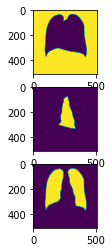

In [5]:
def preprocess_mask(mask):
    mask_np = imageio.imread(mask).astype("float32")
    
    
    mask_ch1 = mask_np[:, :, 0]
    mask_ch1[np.where(mask_ch1 == 0)] = -1
    mask_ch1[np.where((mask_ch1 != 0) & (mask_ch1 != -1))] = 0
    mask_ch1[np.where(mask_ch1 == -1)] = 1
    
    mask_ch2 = mask_np[:, :, 1]
    mask_ch2[np.where(mask_ch2 == 128)] = 1
    mask_ch2[np.where((mask_ch2 != 0) & (mask_ch2 != 1))] = 0
    
    mask_ch3 = mask_np[:, :, 2]
    mask_ch3[np.where(mask_ch3 == 255)] = 1
    mask_ch3[np.where((mask_ch3 != 0) & (mask_ch3 != 1))] = 0
    return mask_np



image_dir = '.\\DataSet\\RY_DataSet_Aug\label\\'
image_paths = [os.path.join(image_dir, image_fname) for image_fname in os.listdir(image_dir)]
preprocessed_mask = preprocess_mask(image_paths[0])

fig, axes = plt.subplots(3, 1)
axes[0].imshow(preprocessed_mask[:, :,0])
axes[1].imshow(preprocessed_mask[:, :,1])
axes[2].imshow(preprocessed_mask[:, :,2])

In [6]:
input_dir = '.\\DataSet\\RY_DataSet_Aug\\xray\\'
target_dir = '.\\DataSet\\RY_DataSet_Aug\\label\\'

# sorted함수를 사용하여 정렬된 파일 리스트를 반환
# 이터러블 객체도 받을 수 있음 
image_list = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir)])
mask_list = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir)])


In [7]:
# from PIL import Image

# input_dir = '.\\DataSet\\RY_DataSet_Aug\\xray\\'
# target_dir = '.\\DataSet\\RY_DataSet_Aug\\label\\'

# # sorted함수를 사용하여 정렬된 파일 리스트를 반환
# # 이터러블 객체도 받을 수 있음 
# image_list = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir)])
# mask_list = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir)])


# def preprocess_image(image):
#     image_np = imageio.imread(image).astype("float32")
    
#     return cv2.resize(image_np, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

# image_dir = '.\\DataSet\\RY_DataSet_preprocess\\image\\'
# mask_dir = '.\\DataSet\\RY_DataSet_preprocess\\mask\\'
# for image, mask in zip(image_list, mask_list):
#     image_np = preprocess_image(image)
#     image_fname = os.path.join(image_dir, os.path.basename(image))
#     cv2.imwrite(image_fname, image_np)
  
#     mask_np = preprocess_mask(mask)
#     mask_fname = os.path.join(mask_dir, os.path.basename(mask))
#     cv2.imwrite(mask_fname, mask_np)
    
  
# val_input_dir = '.\\DataSet\\RY_Test\\CXR\\'
# val_target_dir = '.\\DataSet\\RY_Test\\Label_png\\'

# val_image_list = sorted(
#     [
#         os.path.join(val_input_dir, fname)
#         for fname in os.listdir(val_input_dir)
#     ]
# )

# val_mask_list = sorted(
#     [
#         os.path.join(val_target_dir, fname)
#         for fname in os.listdir(val_target_dir)
#     ]
# )

# image_dir = '.\\DataSet\\RY_DataSet_preprocess\\image_test\\'
# mask_dir = '.\\DataSet\\RY_DataSet_preprocess\\mask_test\\'
# for image, mask in zip(val_image_list, val_mask_list):
#     image_np = preprocess_image(image)
#     image_fname = os.path.join(image_dir, os.path.basename(image))
#     cv2.imwrite(image_fname, image_np)
                               
#     mask_np = preprocess_mask(mask)
#     mask_fname = os.path.join(mask_dir, os.path.basename(mask))
#     cv2.imwrite(mask_fname, mask_np)

In [8]:
image_dir = '.\\DataSet\\RY_DataSet_preprocess\\image\\'
mask_dir = '.\\DataSet\\RY_DataSet_preprocess\\mask\\'
image_list = sorted(
    [
        os.path.join(image_dir, fname)
        for fname in os.listdir(image_dir)
    ])

mask_list = sorted(
    [
        os.path.join(mask_dir, fname)
        for fname in os.listdir(mask_dir)
    ])

In [9]:
val_image_dir = '.\\DataSet\\RY_DataSet_preprocess\\image_test\\'
val_mask_dir = '.\\DataSet\\RY_DataSet_preprocess\\mask_test\\'
val_image_list = sorted(
    [
        os.path.join(val_image_dir, fname)
        for fname in os.listdir(val_image_dir)
    ])

val_mask_list = sorted(
    [
        os.path.join(val_mask_dir, fname)
        for fname in os.listdir(val_mask_dir)
    ])

In [9]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    return img, mask

dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
train_ds = dataset.map(process_path)

val_ds = tf.data.Dataset.from_tensor_slices((val_image_list, val_mask_list))
val_ds = val_ds.map(process_path)

(512, 512, 3) 255
(512, 512, 3) 1 1 1
(512, 512, 3) 255
(512, 512, 3) 1 1 1
(512, 512, 3) 255
(512, 512, 3) 1 1 1


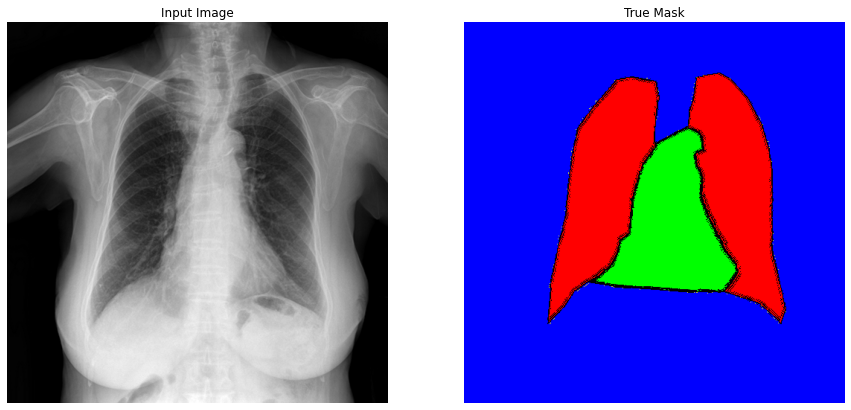

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask', 'Post Processed']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), 'gray')
        plt.axis('off')
    plt.show()
    
for image, mask in train_ds.take(3):
    sample_image, sample_mask = image, mask
    print(image.shape, image.numpy().max())
    print(mask.shape, mask.numpy()[:,:,0].max(), mask.numpy()[:,:,1].max(), mask.numpy()[:,:,2].max())

display([sample_image, sample_mask])

(512, 512, 3) 255
(512, 512, 3) 1 1 1
(512, 512, 3) 255
(512, 512, 3) 1 1 1
(512, 512, 3) 255
(512, 512, 3) 1 1 1


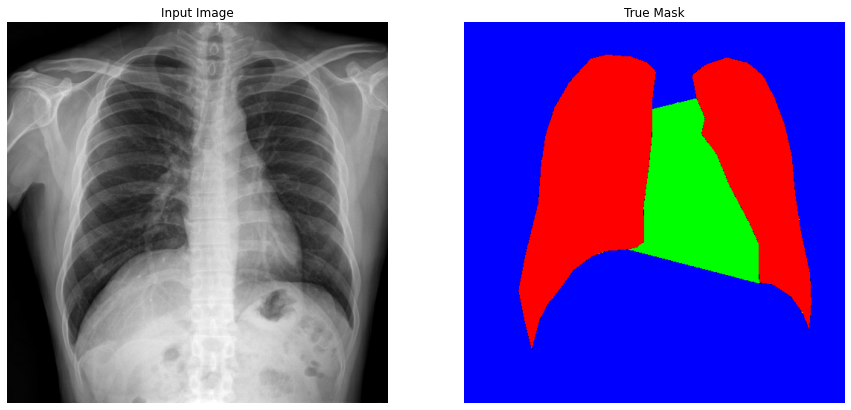

In [11]:
for image, mask in val_ds.take(3):
    sample_image, sample_mask = image, mask
    print(image.shape, image.numpy().max())
    print(mask.shape, mask.numpy()[:,:,0].max(), mask.numpy()[:,:,1].max(), mask.numpy()[:,:,2].max())

display([sample_image, sample_mask])

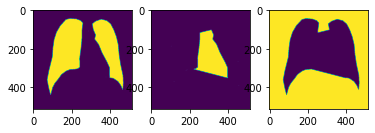

In [12]:
fig, axes = plt.subplots(1, 3) 
axes[0].imshow(sample_mask[:, :,0].numpy())
axes[1].imshow(sample_mask[:, :,1].numpy())
axes[2].imshow(sample_mask[:, :,2].numpy())

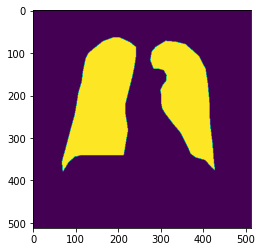

In [13]:
mask = tf.io.read_file("./DataSet\\RY_DataSet_preprocess\\mask_test\\0001.png")
mask = tf.image.decode_png(mask, channels=3)
plt.imshow(mask.numpy()[:,:,0])

In [14]:
# Call-back 함수
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='./MODEL/VGG19-rayence-{epoch:03d}-{loss:.4f}-{accuracy:.4f}-{val_loss:.4f}-{val_accuracy:.4f}.hdf5',
            monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# 학습과정 진행사항 확인
TB = TensorBoard(log_dir='logs', write_graph=True, write_images=True)

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.9,patience=2, verbose=1, min_lr=1e-8)
# patience(3) 번 동안 validation set에서의 loss가 떨어지지 않으면, learning rate를 0.8만큼 곱해라
# 0.001 -> 0.0008 -> 0.00064 -> 0.00051xx...

CALLBACK = [CP, TB, LR]

In [ ]:
BUFFER_SIZE = 500
BATCH_SIZE = 2
train_dataset = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_ds.cache().batch(BATCH_SIZE)

model = TransResUNet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy']
             )

model_history = model.fit(
    train_dataset,
    steps_per_epoch = 150,
    epochs=250,
    validation_data=val_dataset,
    callbacks = CALLBACK)

Epoch 1/250
150/150 [==============================] - ETA: 0s - loss: 101.2457 - accuracy: 0.5187
Epoch 00001: val_loss did not improve from 8.18184
150/150 [==============================] - 57s 321ms/step - loss: 101.2457 - accuracy: 0.5187 - val_loss: 38.9037 - val_accuracy: 0.6861 - lr: 1.0000e-06
Epoch 2/250
150/150 [==============================] - ETA: 0s - loss: 29.4776 - accuracy: 0.7215
Epoch 00002: val_loss did not improve from 8.18184
150/150 [==============================] - 48s 319ms/step - loss: 29.4776 - accuracy: 0.7215 - val_loss: 26.2135 - val_accuracy: 0.7582 - lr: 1.0000e-06
Epoch 3/250
150/150 [==============================] - ETA: 0s - loss: 20.9494 - accuracy: 0.7732
Epoch 00003: val_loss did not improve from 8.18184
150/150 [==============================] - 48s 320ms/step - loss: 20.9494 - accuracy: 0.7732 - val_loss: 20.0954 - val_accuracy: 0.7942 - lr: 1.0000e-06
Epoch 4/250
150/150 [==============================] - ETA: 0s - loss: 16.3344 - accuracy: 0

In [ ]:
plt.plot(model_history.history['accuracy'], label = 'accuracy')
plt.plot(model_history.history['loss'], label = 'loss')
plt.xlabel('epochs')
plt.legend()

In [ ]:
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(model_history.history['val_loss'], label = 'val_loss')
plt.xlabel('epochs')
plt.legend()

In [14]:
for val_image, val_mask in val_ds.take(1):
    break
    
predicted_mask = model(tf.expand_dims(val_image, axis=0))
predicted_mask = predicted_mask.numpy().reshape(512,512,3)

NameError: name 'val_ds' is not defined

In [ ]:
fig, axes = plt.subplots(1, 3) 
axes[0].imshow(predicted_mask[:, :,0])
axes[1].imshow(predicted_mask[:, :,1])
axes[2].imshow(predicted_mask[:, :,2])

In [102]:
# submission

model = TransResUNet()
model.load_weights(os.path.join(os.getcwd(), "MODEL", "VGG19-rayence-001-26.3748-0.6711-33.0198-0.7543.hdf5"))

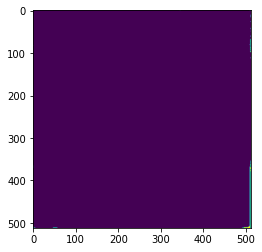

In [104]:
TEST_DATA_DIR = os.path.join(os.getcwd(), "Dataset", "RY_DataSet_test")
jpgs = [os.path.join(TEST_DATA_DIR, jpg) for jpg in os.listdir(TEST_DATA_DIR)]

# jpg = imageio.imread(jpgs[0]).astype("float32").

jpg = tf.image.decode_png(tf.io.read_file(jpgs[0]), channels=3)
resize_jpg = tf.image.resize(jpg, size=(512, 512))
predicted_mask = model.predict(tf.expand_dims(resize_jpg, axis=0))

plt.imshow(np.argmax(predicted_mask[0], axis=-1))

In [94]:
predicted_mask[0][:,:, 0]

array([[1.60019009e-09, 9.54828312e-18, 4.55137504e-17, ...,
        1.04984833e-10, 2.22449792e-09, 1.49853321e-07],
       [6.94457558e-09, 1.51028306e-21, 2.45487496e-21, ...,
        4.72053863e-09, 3.45704711e-06, 3.34284960e-06],
       [4.52873024e-07, 3.14143278e-17, 4.16780277e-19, ...,
        7.15625461e-08, 2.47102832e-07, 1.96182588e-03],
       ...,
       [5.24828070e-10, 5.47152685e-16, 2.70282546e-10, ...,
        2.90158903e-04, 9.90943052e-03, 5.15160337e-02],
       [6.34383980e-07, 8.31125045e-13, 7.75062148e-08, ...,
        3.03448532e-02, 1.00843579e-01, 3.11846614e-01],
       [7.55170106e-07, 9.04618935e-10, 1.25269795e-08, ...,
        9.74969447e-01, 9.66251850e-01, 9.51362789e-01]], dtype=float32)

In [91]:
np.argmax(predicted_mask[0], axis=-1)

array([[1, 1, 1, ..., 1, 2, 1],
       [1, 2, 2, ..., 2, 2, 2],
       [2, 1, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int64)

In [90]:
predicted_mask[0][:, :, 1]

array([[9.9998689e-01, 9.6171975e-01, 9.8843145e-01, ..., 8.4651715e-01,
        6.4026390e-04, 1.3668890e-02],
       [9.9987590e-01, 9.3779624e-09, 2.2518859e-06, ..., 6.2515628e-01,
        7.0314250e-06, 8.3279732e-04],
       [3.4424342e-02, 5.2739193e-07, 1.5413261e-09, ..., 4.8146095e-08,
        1.6620291e-08, 1.2027334e-04],
       ...,
       [2.8463337e-06, 2.3353479e-13, 3.9037052e-13, ..., 2.2120157e-03,
        4.7196120e-02, 2.4011597e-01],
       [4.5528641e-06, 5.9859551e-10, 5.1789232e-13, ..., 4.8251229e-04,
        6.7382073e-03, 7.3326349e-02],
       [1.6235388e-04, 2.0363263e-05, 5.7485668e-08, ..., 7.8498421e-04,
        3.8956672e-02, 2.4111497e-01]], dtype=float32)

TypeError: Image data of dtype <U47 cannot be converted to float

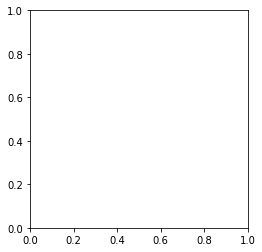

In [86]:
plt.imshow('.\\DataSet\\RY_DataSet_preprocess\\image\\aug_1.png')

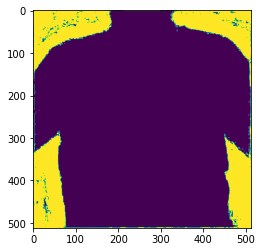

In [73]:
predicted_mask[0][:,:,0]

array([[1.60019009e-09, 9.54828312e-18, 4.55137504e-17, ...,
        1.04984833e-10, 2.22449792e-09, 1.49853321e-07],
       [6.94457558e-09, 1.51028306e-21, 2.45487496e-21, ...,
        4.72053863e-09, 3.45704711e-06, 3.34284960e-06],
       [4.52873024e-07, 3.14143278e-17, 4.16780277e-19, ...,
        7.15625461e-08, 2.47102832e-07, 1.96182588e-03],
       ...,
       [5.24828070e-10, 5.47152685e-16, 2.70282546e-10, ...,
        2.90158903e-04, 9.90943052e-03, 5.15160337e-02],
       [6.34383980e-07, 8.31125045e-13, 7.75062148e-08, ...,
        3.03448532e-02, 1.00843579e-01, 3.11846614e-01],
       [7.55170106e-07, 9.04618935e-10, 1.25269795e-08, ...,
        9.74969447e-01, 9.66251850e-01, 9.51362789e-01]], dtype=float32)

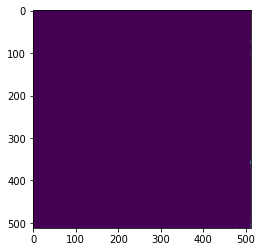

In [61]:
# plt.imshow(predicted_mask[:, :, 0])
plt.imshow(predicted_mask[0][:,:,0])

# Post-Processing for Predicted Lung Masks

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def pprocess(img, SE=(10,30), thresh=15000):
    
    """
    pprocess -- function for post-processing

    Arguments:
    img {numpy.ndarray} -- input image 
    SE {tuple} -- eliptical structuring element shape
    thresh {int} -- threshold value, any connected compnents with pixel area below this value will be eliminated

    Returns: 
    final {numpy.ndarray} -- final post-processed image
    """
    
    ##### Post-processing 1: Hole Filling
    img_in = img
    # Thresholding
    # Setting up values >=200 to 0 and values <200 to 255.
    thres, img_thres = cv2.threshold(img_in, 220, 255, cv2.THRESH_BINARY);

    # Copying the thresholded image.
    img_ffill = img_thres.copy()

    # Mask for flood-filling
    # Here, the size should be 2 pixels larger than the orginal image.
    h, w = img_thres.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Flood-fill starts from node (0, 0)
    cv2.floodFill(img_ffill, mask, (0,0), 255);

    # Invert flood-fill resultant image
    img_ffill_inv = cv2.bitwise_not(img_ffill)
  
    # Bitwise OR (equavalent to union) the two images to get the final hole filled image.
    img_out = img_thres | img_ffill_inv
    

    ##### Post-processing 2: Removing Unwanted Components
    img = img_out/255
    img[img>0.5] = 1
    img[img<=0.5] = 0
    img = morphology.remove_small_objects(img.astype('bool'), thresh)
    img = np.array(img*255, dtype=np.uint8)

    
    ##### Post-processing 3: Morphological Opening 
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, SE))
    
    # Returning the final post-processed image
    return img

# Load fine-tuned model weight

In [ ]:
os.listdir('MODEL')

In [21]:
# model.load_weights( 'MODEL/VGG19-047-0.0211-0.9911-0.0485-0.9830.hdf5' )
val_test_dataset = val_ds.cache().batch(1)

In [22]:
pred_mask = model.predict(image)

ValueError: in user code:

    File "c:\users\sosal\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "c:\users\sosal\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\sosal\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "c:\users\sosal\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "c:\users\sosal\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\sosal\appdata\local\programs\python\python38\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 512, 512, 3), found shape=(32, 512, 3)


In [ ]:
pred_mask = model.predict(image)
pred_mask = np.array(create_mask(pred_mask)).astype('int8')

In [ ]:
pred_mask.shape

In [ ]:
np.array(mask[0]).max()

In [ ]:
Mask = np.array(mask[0])

In [ ]:
Mask.max()

In [ ]:
intersection = np.logical_and(Mask, PostProcess)
union = np.logical_or(Mask, PostProcess)


In [ ]:
pred_

In [ ]:
pred_mask = np.array(create_mask(model.predict(image)))

In [ ]:
pred_mask.max()

In [ ]:
for image, mask in val_test_dataset.take(10):
    pred_mask = model.predict(image)
    pred_mask_tmp = np.array(create_mask(model.predict(image)))
    PostProcess = pprocess((np.array(create_mask(pred_mask))[:,:,0]*255).astype('uint8'), SE = (5, 20), thresh = 5000)[:, :, newaxis]/255
    display([image[0], mask[0], create_mask(pred_mask), PostProcess])

    intersection = np.logical_and(mask[0], pred_mask_tmp)
    union = np.logical_or(mask[0], pred_mask_tmp)
    iou_score1 = np.sum(intersection)/np.sum(union)
    print('Raw pred mask IOU:',iou_score1.round(4))

    intersection = np.logical_and(mask[0], PostProcess)
    union = np.logical_or(mask[0], PostProcess)
    iou_score2 = np.sum(intersection)/np.sum(union)
    print('Post process IOU:',iou_score2.round(4))


In [ ]:
# 훈련이미지와 예측이미지 비교
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            PostProcess = pprocess((np.array(create_mask(pred_mask))[:,:,0]*255).astype('uint8'), SE = (5, 20), thresh = 5000)[:, :, newaxis]
            display([image[0], mask[0], create_mask(pred_mask), PostProcess])
    else:
        display([sample_image, sample_mask/128, create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
show_predictions(val_test_dataset, 10)

In [ ]:
def display_alpha(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask', 'Post Processed']

    plt.subplot(1, len(display_list), 1)

    plt.title(title[0])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]), 'gray')
    plt.axis('off')
    
    for i in range(1, len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]), 'gray')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), 'jet', alpha=0.3)
        plt.axis('off')
    plt.show()

In [ ]:
# 훈련이미지와 예측이미지 비교
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            PostProcess = pprocess((np.array(create_mask(pred_mask))[:,:,0]*255).astype('uint8'), SE = (5, 20), thresh = 5000)[:, :, newaxis]
            display_alpha([image[0], mask[0], create_mask(pred_mask), PostProcess])
    else:
        display_alpha([sample_image, sample_mask/128, create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
show_predictions(val_test_dataset, 10)

In [ ]:
img.max()

In [ ]:
original_img = cv2.imread('SampleImage/sampleOutput.png',0)

SE = [(2, 10), (5, 20), (10, 30), (10, 50)]
Threshold = [3000, 6000]

processed_imgs = [original_img]
for _SE in SE:
    for _Threshold in Threshold:
        processed_imgs.append(pprocess(original_img, _SE, _Threshold))